In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *


In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]


In [4]:
PATH = 'data/planet/'

In [5]:
ls {PATH}

__MACOSX/                     test-tif-v2.tar.7z            train-tif-v2/
models/                       test_v2_file_mapping.csv      train-tif-v2.tar.7z
sample_submission_v2.csv.zip  test_v2_file_mapping.csv.zip  train_v2.csv
test-jpg/                     tmp/                          train_v2.csv.zip
test-jpg-additional.tar.7z    train-jpg/
test-jpg.tar.7z               train-jpg.tar.7z


In [6]:
label_csv = f'{PATH}train_v2.csv'

In [7]:
label_df = pd.read_csv(label_csv)

In [8]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
metrics=[f2]

In [10]:
n = len(list(open(label_csv)))-1

In [11]:
val_idxs = get_cv_idxs(n)

In [12]:
get_cv_idxs

<function fastai.dataset.get_cv_idxs>

In [13]:
f_model = resnet34

In [14]:
#create a get data function that allows you to pass in a size
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH,'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [15]:
data = get_data(256)

In [16]:
iter(data.val_dl)

In [17]:
x,y = next(iter(data.val_dl))

In [18]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [19]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [20]:
y[0]


 1
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 1
[torch.FloatTensor of size 17]

In [21]:
list(zip(data.classes,y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

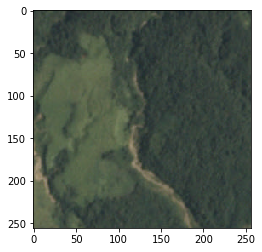

In [22]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]);

In [23]:
sz=64

In [24]:
data = get_data(sz)

In [25]:
data = data.resize(int(sz*1.4),'tmp')

A Jupyter Widget

In [26]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [27]:
lrf = learn.lr_find()

A Jupyter Widget

[ 0.       0.21473  0.33852  0.80459]                        



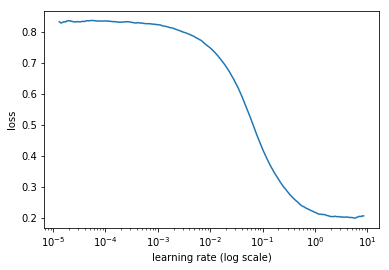

In [28]:
learn.sched.plot()

In [29]:
lr = 0.2

In [30]:
learn.fit(lr,4, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.1459   0.13563  0.87816]                        
[ 1.       0.13794  0.12969  0.88572]                        
[ 2.       0.13493  0.12834  0.88633]                        
[ 3.       0.13513  0.12874  0.8857 ]                        
[ 4.       0.13428  0.12574  0.88964]                        
[ 5.       0.1299   0.12442  0.89009]                        
[ 6.       0.1299   0.12417  0.89104]                        
[ 7.       0.13184  0.12583  0.88947]                        
[ 8.       0.1343   0.12405  0.89068]                        
[ 9.       0.12923  0.12397  0.89169]                        
[ 10.        0.12826   0.12286   0.89235]                    
[ 11.        0.12302   0.1218    0.89302]                    
[ 12.        0.1292    0.1225    0.89191]                    
[ 13.        0.12771   0.12152   0.89329]                    
[ 14.        0.12549   0.12233   0.89176]                    



In [32]:
lrs = np.array([lr/10,lr/3,lr])

In [33]:
learn.unfreeze()

In [34]:
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

A Jupyter Widget

[ 0.       0.11672  0.11265  0.9023 ]                        
[ 1.       0.11175  0.10783  0.90664]                        
[ 2.       0.1039   0.1043   0.90971]                        
[ 3.       0.10966  0.10985  0.90459]                        
[ 4.       0.10544  0.10398  0.91074]                        
[ 5.       0.10049  0.09948  0.91528]                         
[ 6.       0.09705  0.10163  0.91401]                         



In [36]:
learn.save(f'{sz}')

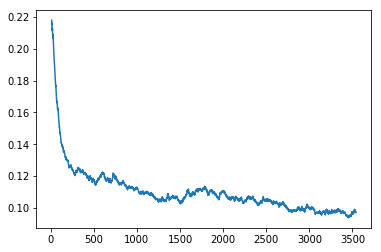

In [38]:
learn.sched.plot_loss()

In [40]:
sz=128

In [41]:
learn.set_data(get_data(sz))

In [45]:
learn.freeze()

In [46]:
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

A Jupyter Widget

[ 0.       0.09702  0.09873  0.91487]                         
[ 1.       0.09789  0.09776  0.91579]                         
[ 2.       0.09694  0.09719  0.91654]                         
[ 3.       0.09565  0.09558  0.91816]                         
[ 4.       0.09531  0.09537  0.91804]                         
[ 5.       0.09656  0.09614  0.91672]                         
[ 6.       0.09195  0.09452  0.91892]                         



In [51]:
learn.save(f'{sz}')

In [53]:
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

A Jupyter Widget

[ 0.       0.09543  0.09542  0.91724]                         
[ 1.       0.09421  0.09545  0.91774]                         
[ 2.      0.0913  0.0946  0.9183]                             
[ 3.       0.09513  0.09511  0.91798]                         
[ 4.       0.09064  0.09424  0.91881]                         
[ 5.       0.09179  0.09426  0.91856]                         
[ 6.       0.09263  0.09528  0.91777]                         



In [54]:
learn.save(f'{sz}')

In [55]:
sz=256

In [56]:
learn.set_data(get_data(sz))

In [58]:
learn.freeze()

In [59]:
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

A Jupyter Widget

[ 0.       0.10448  0.1044   0.90859]                        
[ 1.       0.1024   0.1008   0.91298]                         
[ 2.       0.10272  0.10132  0.91156]                         
[ 3.       0.10147  0.10074  0.91281]                         
[ 4.       0.09946  0.09987  0.91348]                         
[ 5.       0.0975   0.09979  0.91361]                         
[ 6.       0.09778  0.09851  0.91478]                         



In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09115  0.09002  0.92308]                         
 84%|████████▎ | 423/506 [12:34<02:28,  1.78s/it, loss=0.0908]

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)